In [1]:
import pandas as pd
import numpy as np
import cooler
import matplotlib.pyplot as plt
import matplotlib.colors
from matplotlib.patches import Patch
from matplotlib.offsetbox import AnchoredText
import scipy.io
import pyBigWig
import gget
import pysam
from sklearn.preprocessing import MultiLabelBinarizer

import os
import sys
from importlib import reload

import filters
import pore_c_utils as pcu
import binning_utils as binning
import plotting as hicPlot

In [2]:
assembly = pcu.loadAssembly("GRCm39_Assembly.txt")

chromDict = dict(zip(assembly['RefSeq accession'],assembly['Chromosome'].apply(lambda x : f"chr{x}")))

# the reverse for easy lookup
chromDict_r = {v: k for k, v in chromDict.items()}
chromOrder = list(chromDict.values())

In [3]:
filepath = "filtered_data/clique1MBfiltered.csv"

df = pd.read_csv(filepath)
df['filterType'] = 'expanded'

print(f"{df.shape=}")

/sw/arcts/centos7/python3.8-anaconda/2020.07/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3343: DtypeWarning: Columns (39) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


df.shape=(636130, 66)


In [4]:
# resolution = 100000 # 100kb scale
resolution = 1000000 # 1Mb scale
# resolution = 10000000 # 10Mb scale

totalLength = assembly['chromEnd'].max()
bins = binning.getBins(totalLength, resolution)

label1 = 'bin1'
label2 = 'bin2'

newRows = []
matrices = {}

for cell in df['cell'].unique():
    
    tmp = df[(df['cell'] == cell)].reset_index(drop=True)
    cellBinned = binning.wholeGenomeBinData(tmp, bins, label1, label2)
    
    A = pcu.getHic(cellBinned, bins, label1, label2)
    print(f"{cell=} {A.shape=}")
    matrices[cell] = A
    newRows.append(cellBinned)
    
df = pd.concat(newRows, ignore_index=True)
print(f"{df.shape=}")
print('done.')

cell='run01' A.shape=(2724, 2724)
cell='run02' A.shape=(2724, 2724)
cell='run04' A.shape=(2724, 2724)
cell='run05' A.shape=(2724, 2724)
cell='run06' A.shape=(2724, 2724)
cell='run07' A.shape=(2724, 2724)
df.shape=(636130, 68)
done.


In [5]:
newRows = []

for idx, row in assembly.iterrows():
    if "NC" in row['RefSeq accession']:
        
        start = binning.returnBin(row['chromStart'], bins) + 2
        end = binning.returnBin(row['chromEnd'], bins) + 3
        
        newRow = {
            'region' : f"chr{row['Chromosome']}",
            'start' : start,
            'end' : end,
            'length' : end - start,
        }
        
        newRows.append(newRow)
        
filteredChromInfo = pd.DataFrame(newRows)

filteredPoreCIndex = list(range(0, int(max(bins) / resolution)))
print(f"{len(filteredPoreCIndex)=}")

len(filteredPoreCIndex)=2724


In [6]:
filteredChromInfo.head()

,region,start,end,length
0,chr1,1,197,196
1,chr2,196,378,182
2,chr3,377,538,161
3,chr4,537,695,158
4,chr5,694,847,153


In [7]:
# load tads 
tad = pd.read_csv('F121_mESC_TADS.txt', sep='\t', header=None)
tad.columns = ['id', 'start', 'end', 'undef']
tad['phase'] = tad['id'].apply( lambda x: x.split("_")[0])
tad['chrom'] = tad['id'].apply( lambda x: x.split("_")[1])

print(f"{tad.shape=}")

tadChr2 = tad[(tad['chrom'] == '2') & (tad['phase'] == 'G1')].reset_index(drop=True)
print(f"{tadChr2.shape=}")


binStart = []
binEnd = []

for idx, row in tadChr2.iterrows():
    tadStart = binning.returnBin(row['start'], bins)
    tadEnd = binning.returnBin(row['end'], bins)
    
    binStart.append(tadStart)
    binEnd.append(tadEnd)
    
tadChr2['binStart'] = binStart
tadChr2['binEnd'] = binEnd
tadChr2['tadLen'] = tadChr2['binEnd'] - tadChr2['binStart']

tadChr2.head()

tad.shape=(4104, 6)
tadChr2.shape=(160, 6)


,id,start,end,undef,phase,chrom,binStart,binEnd,tadLen
0,G1_2,154413264,154595264,20,G1,2,153,153,0
1,G1_2,152671264,153584264,20,G1,2,151,152,1
2,G1_2,156370264,157570264,20,G1,2,155,156,1
3,G1_2,30076480,30354480,20,G1,2,29,29,0
4,G1_2,164950500,165729500,20,G1,2,163,164,1


In [8]:
chromosome = ['chr2']

chrom2 = {}

def processMat(fullMat, ind):
    """streamline a few procedures on both datasets"""
    A = fullMat[:, ind][ind, :]
    A = np.where(A > 0, 1, 0)
    np.fill_diagonal(A, 1)
    return A
    

for runId in matrices.keys():
    ind = pcu.getIndices(filteredChromInfo, filteredPoreCIndex, chromosome, 'region')
    A = processMat(matrices[runId], ind)
    chrom2[runId] = A
    
    
print('done.')

done.


In [9]:
# build ensemble 

# ensemble = np.zeros((182, 182))

# for k, v in chrom2.items():
#     ensemble += v
    
# print('done')

In [10]:
# chrom = 2

# ch = df[df['align1_chromosome_name'] == str(chrom)]
# ch = ch[ch['align2_chromosome_name'] == str(chrom)]

# ch['minPairBin'] = ch[['bin1', 'bin2']].min(axis=1)
# ch = ch.sort_values(by=['minPairBin', 'read_name'], ascending=True)

# minBin = np.min(ch['bin1'].to_list() + ch['bin2'].to_list())

# print(f"{ch.shape=}")

# matplotlib.rcParams['figure.dpi'] = 200
# matplotlib.rcParams['figure.figsize'] = 45, 10

# contactInd = 0
    
# for i, read in enumerate(ch['read_name'].unique()):
#     t = ch[ch['read_name'] == read]
#     contacts = list(set(t['bin1'].to_list() + t['bin2'].to_list()))
    
#     contacts = [x - minBin for x in contacts]

#     if len(contacts) > 1:
        
#         contactInd += 1
#         readPlotInd = [contactInd] * len(contacts)
        
#         plt.plot(readPlotInd, 
#                  contacts,
#                  c='k', 
#                  alpha=0.5,
#                  lw=1, 
#                  zorder=1)

#         plt.scatter(readPlotInd, 
#                     contacts, 
#                     s=5, 
#                     marker='s',
#                     facecolor='k', 
#                     edgecolor='None',
#                     zorder=2)
        
# plt.xlabel('Read')
# xticks = list(range(contactInd))
# plt.gca().set_xticks(xticks)

# plt.gca().set_xticklabels([])
# plt.ylabel('Bin (1Mb)')
# plt.tight_layout()
# plt.xlim(0, contactInd)
# plt.ylim(183, -1)
# plt.grid(axis='y')

# # for idx, row in tadChr2.iterrows():
# #     plt.axvline(x=row['binStart'], ls='--', c='b', alpha=0.5, lw=0.2)

In [11]:
# # create an 'unfolded' data structure, basically an indicence matrix
# # but it's actually a hash table

# d = {}

# nReads = df['read_name'].nunique()

# for i, read in enumerate(df['read_name'].unique()):
    
#     if i % 10000 == 0:
#         print(f"{i/nReads:.2f} done")
    
#     tmp = df[df['read_name'] == read]
    
#     allCells = list(set(tmp['cell'].to_list()))
#     allBins = tmp['bin1'].to_list() + tmp['bin2'].to_list()
#     allChroms = tmp['align1_chromosome_name'].to_list() + tmp['align2_chromosome_name'].to_list()
#     allPos = tmp['align1_absolute_midpoint'].to_list() + tmp['align2_absolute_midpoint'].to_list()
#     order = len(set(allPos))
    
#     # gotcha!
#     if len(allCells) > 1:
#         print(read_name)
    
#     d[read] = {
#         'bins' : allBins,
#         'chromosomes' : allChroms,
#         'positions' : allPos,
#         'cell' : allCells,
#         'order' : order,
#     }

# print('done.')

In [12]:
# newRows = []

# for k, v in d.items():
    
#     row = {
#         "read_name" : k,
#         'bins' : ';'.join(str(x) for x in v['bins']),
#         'chromosomes' :  ';'.join(str(x) for x in v['chromosomes']),
#         'positions' :  ';'.join(str(x) for x in v['positions']),
#         'cell' : v['cell'][0],
#         'order' : v['order']
#     }
    
#     newRows.append(row)
    
    
# hf = pd.DataFrame(newRows)
# print(f"{hf.shape=}")
# hf.to_csv("filtered_data/incidence.csv", index=False)
# hf.head()
    

In [13]:
hf = pd.read_csv("filtered_data/incidence.csv")
print(f"{hf.shape=}")
hf.head()

hf.shape=(188957, 6)


,read_name,bins,chromosomes,positions,cell,order
0,132f1be4-df3c-4a1f-bc53-40df856b0c42,2629;2629;2629;2629;2629;2629;2629;2629,X;X;X;X;X;X;X;X,2630943949;2630904730;2630904730;2630904730;26...,run01,3
1,b0e13742-1d17-47d9-a017-668f37b6788f,2629;2629;2629;2629;2629;2629,X;X;X;X;X;X,2630229012;2630226522;2630226522;2630944366;26...,run01,3
2,330b862a-138c-48d7-9534-be879100a320,2629;2629,X;X,2630227938;2630229781,run01,2
3,af44682d-de48-467d-8cd2-f79d45b85f69,2629;2629,X;X,2630227390;2630956993,run01,2
4,7470a373-22cb-49b2-a0df-9e5279d9559c,2629;2629;2629;2629,X;X;X;X,2630227390;2630226522;2630943949;2630943949,run01,3


In [14]:
chromTrans = {
    "1"  : 1,
    "2"  : 2,
    "3"  : 3,
    "4"  : 4,
    "5"  : 5,
    "6"  : 6,
    "7"  : 7,
    "8"  : 8,
    "9"  : 9,
    "10" : 10,
    "11" : 11,
    "12" : 12,
    "13" : 13,
    "14" : 14,
    "15" : 15,
    "16" : 16,
    "17" : 17,
    "18" : 18,
    "19" : 19,
    "X"  : 20,
}

In [15]:
hf.head()

,read_name,bins,chromosomes,positions,cell,order
0,132f1be4-df3c-4a1f-bc53-40df856b0c42,2629;2629;2629;2629;2629;2629;2629;2629,X;X;X;X;X;X;X;X,2630943949;2630904730;2630904730;2630904730;26...,run01,3
1,b0e13742-1d17-47d9-a017-668f37b6788f,2629;2629;2629;2629;2629;2629,X;X;X;X;X;X,2630229012;2630226522;2630226522;2630944366;26...,run01,3
2,330b862a-138c-48d7-9534-be879100a320,2629;2629,X;X,2630227938;2630229781,run01,2
3,af44682d-de48-467d-8cd2-f79d45b85f69,2629;2629,X;X,2630227390;2630956993,run01,2
4,7470a373-22cb-49b2-a0df-9e5279d9559c,2629;2629;2629;2629,X;X;X;X,2630227390;2630226522;2630943949;2630943949,run01,3


In [16]:
hf['chromList'] = hf['chromosomes'].apply(lambda x: x.split(";"))

mlb = MultiLabelBinarizer()

incidence = pd.DataFrame(mlb.fit_transform(hf['chromList']),
                   columns=mlb.classes_,
                   index=hf.index)

print(f"{incidence.shape=}")

outpath = "filtered_data/scPoreCIncidence1Mb.csv"
incidence.to_csv(outpath, index=False)

incidence['nChroms'] = incidence.sum(axis=1)
# incidence = incidence[incidence['nChroms'] > 1]
incidence = incidence.sort_values(by='nChroms', ascending=False)
print(f"{incidence.shape=}")

incidence.head()

incidence.shape=(188957, 20)
incidence.shape=(188957, 21)


,1,10,11,12,13,14,15,16,17,18,...,2,3,4,5,6,7,8,9,X,nChroms
80680,1,0,0,1,0,1,1,0,1,0,...,0,0,0,1,0,1,0,0,0,7
164067,0,0,0,0,1,1,0,0,0,0,...,1,0,0,0,0,1,1,0,0,6
170345,0,1,1,0,1,1,0,0,0,0,...,0,0,0,1,0,1,0,0,0,6
61916,1,0,0,0,1,1,0,0,0,0,...,1,0,1,0,0,0,0,0,0,5
80113,1,0,0,0,0,0,1,1,0,1,...,0,0,0,0,1,0,0,0,0,5


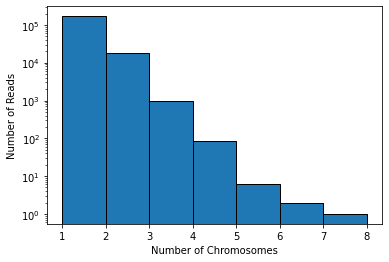

In [17]:
histBins = np.linspace(1, 8, 8)
plt.hist(incidence['nChroms'], bins=histBins, edgecolor='k')
plt.xlabel('Number of Chromosomes')
plt.ylabel('Number of Reads')
plt.yscale("log")

In [18]:
mlb.classes_

array(['1', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19',
       '2', '3', '4', '5', '6', '7', '8', '9', 'X'], dtype=object)

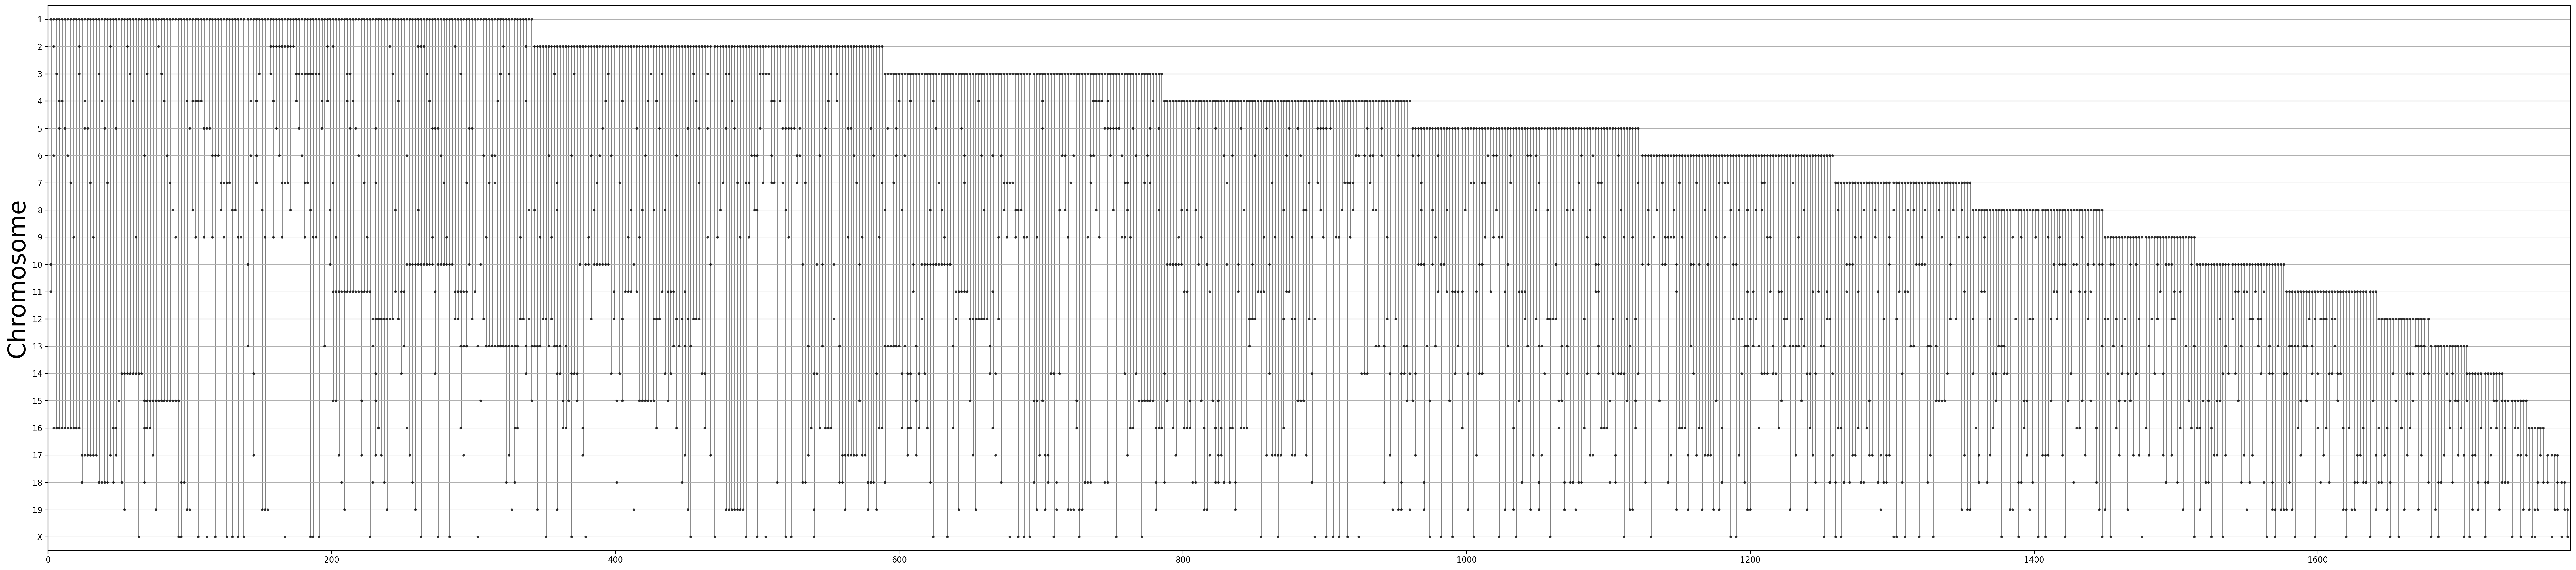

In [19]:
matplotlib.rcParams['figure.dpi'] = 200
matplotlib.rcParams['figure.figsize'] = 45, 10

chromNameCols = list(mlb.classes_)

# count the higher-order contacts to find most frequent
grp = incidence.groupby(chromNameCols)['nChroms'].count().reset_index()
grp.columns = chromNameCols + ['n']
grp['nNorm'] = grp['n'].apply(lambda x: x / grp['n'].max())

# find the minimum chromosome for plotting order
minChroms = []
for idx, row in grp.iterrows():
    mask = row[chromNameCols] == 1
    hits = np.array(chromNameCols)[mask.to_list()]
    minChrom = np.min([chromTrans[i] for i in hits])
    minChroms.append(minChrom)
    

grp['minChrom'] = minChroms
grp = grp.sort_values(by='minChrom', ascending=True)

contactInd = 0
for idx, row in grp.iterrows():
    
    contactInd += 1
    mask = row[chromNameCols] > 0
    toPlot = row[chromNameCols][mask]
    
    if len(toPlot) > 1:
        contactInd += 1
        plotChroms = [chromTrans[x] for x in toPlot.index] 
        plotInd = [contactInd] * len(plotChroms)

        plt.plot(plotInd, 
                 plotChroms,
                 c = 'k',
                 alpha=0.5,
#                  lw=row['nNorm'] * 500,
                 lw=1,
                 zorder=1)

        plt.scatter(plotInd, 
                    plotChroms, 
#                     s=np.sqrt(row['n']) * 4, 
                    s=10, 
                    alpha=0.8,
#                     marker='s',
                    facecolor='k',
                    edgecolor='None',
                    zorder=2)
    
plt.ylabel('Chromosome', fontsize=30)
plt.tight_layout()
plt.xlim(0, contactInd)
plt.ylim(20.5, 0.5)  
    
plt.gca().set_yticks(list(chromTrans.values()))
plt.gca().set_yticklabels(list(chromTrans.keys()))
plt.grid(axis='y')

In [20]:
hf['nChrom'] = hf['chromList'].apply(lambda x: len(set(x)))

def getChrom(chromList, chrom="2"):
    ind = []
    for i in range(len(chromList)):
        if chromList[i] == chrom:
            ind.append(i)
    return ind

def getChrBins(ind, bins):
    binSplit = bins.split(";")
    chromBins = []
    for i in ind:
        chromBins.append(binSplit[i])
    return chromBins
        
        
# get all chr2 contacts
hf['chr2Ind'] = hf['chromList'].apply(lambda x: getChrom(x))
hf['chr2Hits'] = hf['chr2Ind'].apply(lambda x: len(x))

print(f"{hf.shape=}")
chr2 = hf[hf['chr2Hits'] > 0]
print(f"{chr2.shape=}")

# get bin positions of chr2 contacts
chr2['chr2Contacts'] = chr2.apply(lambda x: getChrBins(x.chr2Ind, x.bins), axis=1)

chr2.head()

hf.shape=(188957, 10)
chr2.shape=(15940, 10)


<ipython-input-20-08257258b0e1>:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  chr2['chr2Contacts'] = chr2.apply(lambda x: getChrBins(x.chr2Ind, x.bins), axis=1)


,read_name,bins,chromosomes,positions,cell,order,chromList,nChrom,chr2Ind,chr2Hits,chr2Contacts
510,7d39add3-abcb-481d-99a2-b66582e241e2,2527;2527;281;281;281;2527;2527;2527;2527;2527,X;X;2;2;2;X;X;X;X;X,2528858941;2528858941;282700265;282700265;2827...,run01,3,"[X, X, 2, 2, 2, X, X, X, X, X]",2,"[2, 3, 4]",3,"[281, 281, 281]"
581,97a13729-38f1-4f8b-9b02-55c9f308ee85,2518;283;283;2518;2518;2518,X;2;2;X;X;X,2519457135;284077014;284077014;2519478167;2519...,run01,3,"[X, 2, 2, X, X, X]",2,"[1, 2]",2,"[283, 283]"
1284,1da1387a-c590-44a3-8088-9e3db804fb73,2399;2399;2399;331;331;331;331;331;331;2399;23...,18;18;18;2;2;2;2;2;2;18;18;18;18;18;18;18;18;18,2400400281;2400400930;2400400281;332166742;332...,run01,4,"[18, 18, 18, 2, 2, 2, 2, 2, 2, 18, 18, 18, 18,...",2,"[3, 4, 5, 6, 7, 8]",6,"[331, 331, 331, 331, 331, 331]"
1557,8bf2b697-812b-4a4c-b34a-5bc82da2d2f2,2367;2367;332;332;332;2367;2367;2367;2367;2367,18;18;2;2;2;18;18;18;18;18,2368728849;2368728849;333211026;333211026;3332...,run01,4,"[18, 18, 2, 2, 2, 18, 18, 18, 18, 18]",2,"[2, 3, 4]",3,"[332, 332, 332]"
2848,80860f4a-9acd-4ac3-b9ee-4f2f6df47334,2233;283;283;283;283;283;283;283;2234;2234;223...,17;2;2;2;2;2;2;2;17;17;17;17;17;17;17;2,2234991445;284603180;284603180;284604036;28460...,run01,5,"[17, 2, 2, 2, 2, 2, 2, 2, 17, 17, 17, 17, 17, ...",2,"[1, 2, 3, 4, 5, 6, 7, 15]",8,"[283, 283, 283, 283, 283, 283, 283, 283]"


In [21]:
# define chr2 incidence matrix
mlb = MultiLabelBinarizer()

incidence = pd.DataFrame(mlb.fit_transform(chr2['chr2Contacts']),
                   columns=mlb.classes_,
                   index=chr2.index)

print(f"{incidence.shape=}")

incidence['nBins'] = incidence.sum(axis=1)
# incidence = incidence[incidence['nChroms'] > 1]
incidence = incidence.sort_values(by='nBins', ascending=False)
print(f"{incidence.shape=}")

incidence.head()

incidence.shape=(15940, 179)
incidence.shape=(15940, 180)


,197,198,199,200,201,202,203,204,205,206,...,367,368,369,370,371,372,373,374,375,nBins
91146,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,4
64212,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,4
64146,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,4
41451,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,4
184430,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,4


/home/cstansbu/.local/lib/python3.8/site-packages/pandas/core/series.py:1442: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  return df.reset_index(level=level, drop=drop)


(376.0, 195.0)

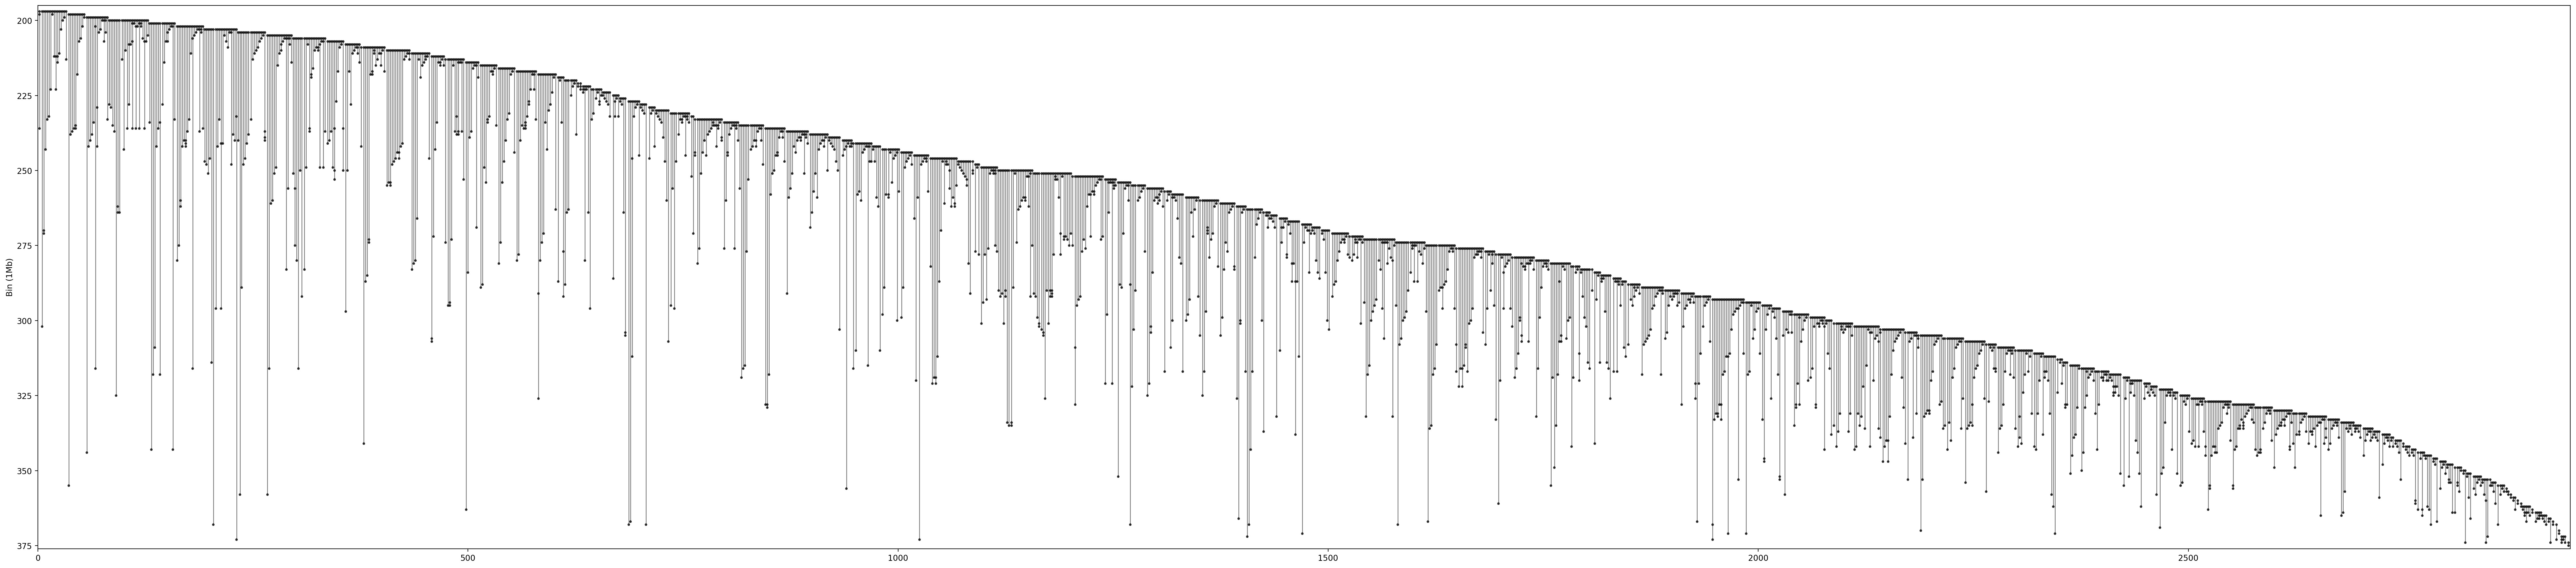

In [22]:
# count the contact frequency
contactNameCols = list(mlb.classes_)

grp = incidence.groupby(contactNameCols)['nBins'].count().reset_index()
grp.columns = contactNameCols + ['n']


minBins = []

for idx, row in grp.iterrows():
    mask = row[contactNameCols] == 1
    hits = np.array(contactNameCols)[mask.to_list()]
    minBin = np.min([int(i) for i in hits])
    minBins.append(minBin)
    
grp['minBin'] = minBins
grp = grp.sort_values(by='minBin', ascending=True)


contactInd = 0
for idx, row in grp.iterrows():
    
    contactInd += 1
    mask = row[contactNameCols] > 0
    toPlot = row[contactNameCols][mask]

    
    if len(toPlot) > 1:
        contactInd += 1
        plotContacts = [int(x) for x in toPlot.index] 
        plotInd = [contactInd] * len(plotContacts)

        plt.plot(plotInd, 
                 plotContacts,
                 c = 'k',
                 alpha=0.5,
#                  lw=row['nNorm'] * 500,
                 lw=1,
                 zorder=1)

        plt.scatter(plotInd, 
                    plotContacts, 
#                     s=np.sqrt(row['n']) * 4, 
                    s=10, 
                    alpha=0.8,
#                     marker='s',
                    facecolor='k',
                    edgecolor='None',
                    zorder=2)
    
plt.ylabel('Bin (1Mb)')
plt.tight_layout()
plt.xlim(0, contactInd)
plt.ylim(376, 195)  
    
# plt.gca().set_yticks(list(chromTrans.values()))
# plt.gca().set_yticklabels(list(chromTrans.keys()))
# plt.grid(axis='y')